The following code is based on [this tutorial](https://www.youtube.com/watch?v=zp8clK9yCro).

In [1]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Get data
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

data_loader = DataLoader(mnist_data, batch_size=64, shuffle=True)

In [3]:
# Analyze data

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [4]:
# Define a basic AutoEncoder 
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N (batch size), 1 (channels), 28 (width), 28 (height)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 1, 28, 28 -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 16, 14, 14 -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # N, 32, 7, 7 -> N, 64, 1, 1
            nn.ReLU(),
        )

        # decoder input siz: N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), #  N, 64, 1, 1 -> N, 32, 7, 7 
            nn.ReLU(),
            # nn.ConvTranspose2d(32, 16, 3), #  N, 32, 7, 7 -> N, 16, 13, 13 THE DIMENSIONS WOULD NOT ADD UP!!
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), #  N, 32, 7, 7 -> N, 16, 14, 14 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), #  N, 16, 14, 14 -> N, 1, 28, 28
            nn.Sigmoid() # IMPORTTANT! Depending on data we might need different activation here!
        )
# NOTE: Last activation: [0, 1] -> nn.ReLU(), [-1, 1] -> nn.Tanh
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# NOTE: if you use nn.MaxPool2d() to reduce size, its inverse is nn.MaxUnpool2d()

In [5]:
# Instantiate neural net and optimizer
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [6]:
# Train the Autoencoder
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for img, _ in data_loader:
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch+1}, Loss:{loss.item():.4f}")
    outputs.append((epoch, img, recon))


Epoch:1, Loss:0.0089
Epoch:2, Loss:0.0070
Epoch:3, Loss:0.0045
Epoch:4, Loss:0.0044
Epoch:5, Loss:0.0043
Epoch:6, Loss:0.0041
Epoch:7, Loss:0.0034
Epoch:8, Loss:0.0039
Epoch:9, Loss:0.0036
Epoch:10, Loss:0.0034


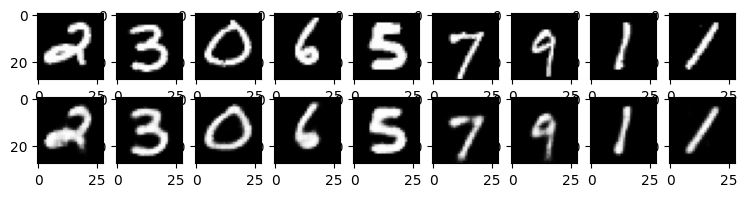

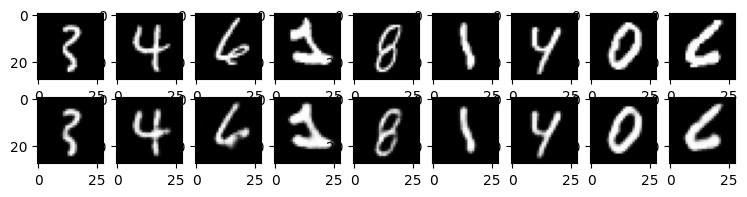

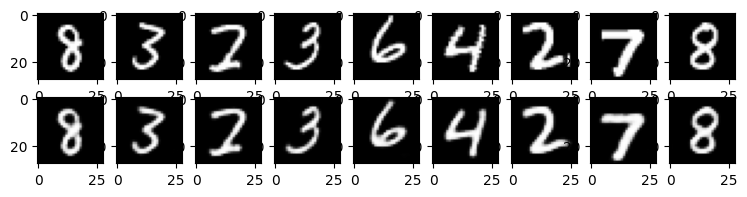

In [7]:
# Plot the reconstructed images
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()

    for i, item in enumerate(imgs):
        if i >= 9: break

        plt.subplot(2, 9, i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.tick_params(left = False, 
                        right = False,
                        labelleft = False,
                        labelbottom = False,
                        bottom = False
                        )
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])